All libraries imported successfully
Dataset Shape: (1041, 18)

Columns: ['Age', 'Gender', 'StudyHours', 'SleepHours', 'ReviewCenter', 'MockExamScore', 'GPA', 'Scholarship', 'InternshipGrade', 'IncomeLevel', 'EmploymentStatus', 'Confidence', 'TestAnxiety', 'EnglishProficiency', 'MotivationScore', 'SocialSupport', 'ExamResultPercent', 'Passed']
DATA EXPLORATION

Missing Values:
MockExamScore      478
InternshipGrade      6
dtype: int64

Target Distribution:
count    1041.000000
mean       76.514601
std         2.483313
min        63.800000
25%        74.900000
50%        76.400000
75%        78.300000
max        81.800000
Name: ExamResultPercent, dtype: float64


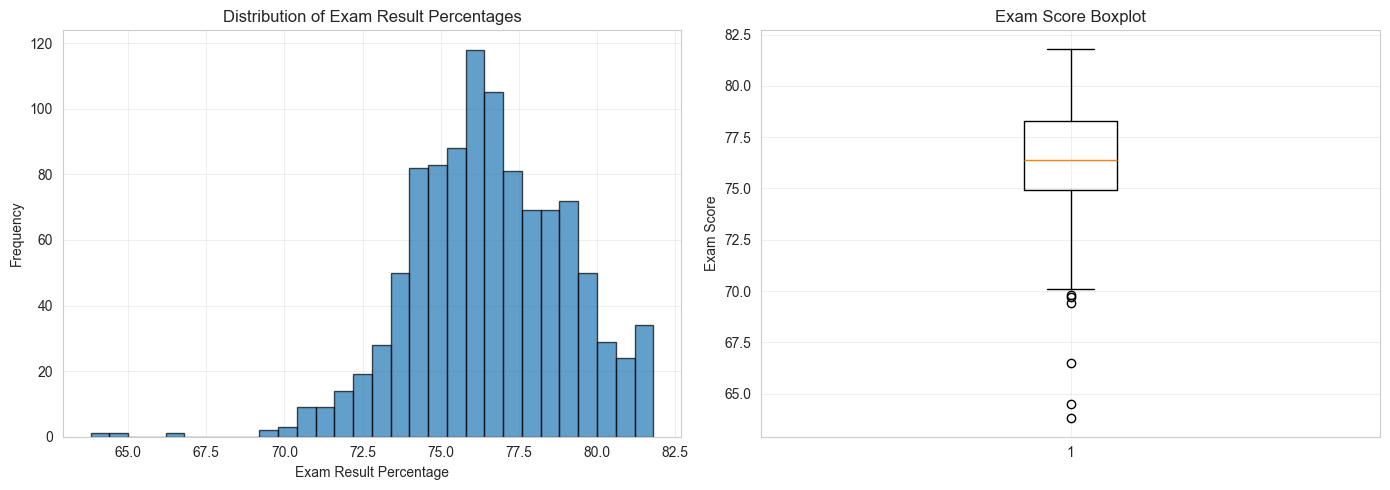

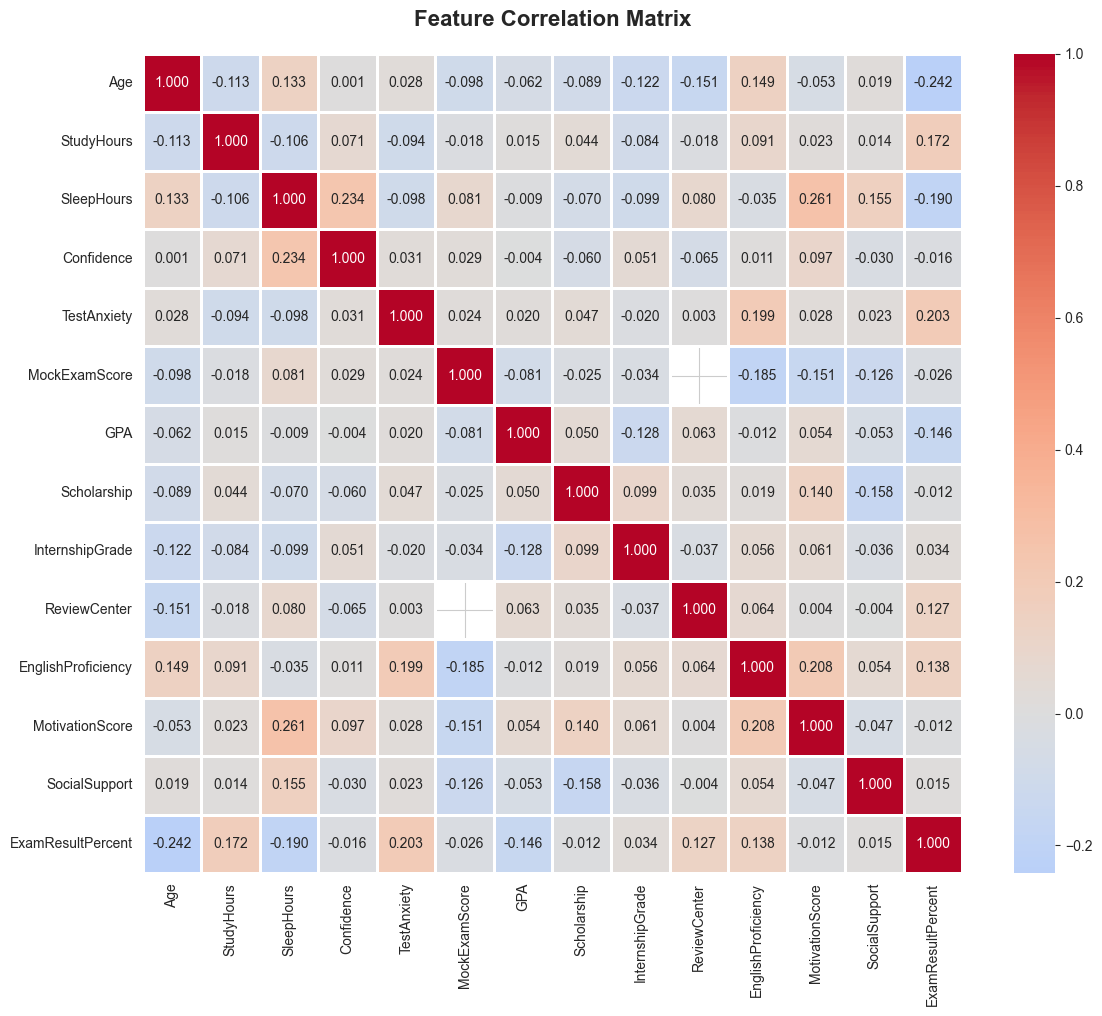


Top Features Correlated with Exam Result Percentage:
   Age: 0.2422
   TestAnxiety: 0.2032
   SleepHours: 0.1903
   StudyHours: 0.1720
   GPA: 0.1456
   EnglishProficiency: 0.1382
   ReviewCenter: 0.1275
   InternshipGrade: 0.0340
   MockExamScore: 0.0263
   Confidence: 0.0156
FEATURE IMPORTANCE ANALYSIS

[STEP 1] Handling Missing Values...
Missing values before imputation:
Age                     0
Gender                  0
StudyHours              0
SleepHours              0
ReviewCenter            0
MockExamScore         478
GPA                     0
Scholarship             0
InternshipGrade         6
IncomeLevel             0
EmploymentStatus        0
Confidence              0
TestAnxiety             0
EnglishProficiency      0
MotivationScore         0
SocialSupport           0
dtype: int64

Imputing grade-based columns with IterativeImputer (regression)...

Imputing score-based columns with median...

Missing values after imputation:
Age                   0
Gender                

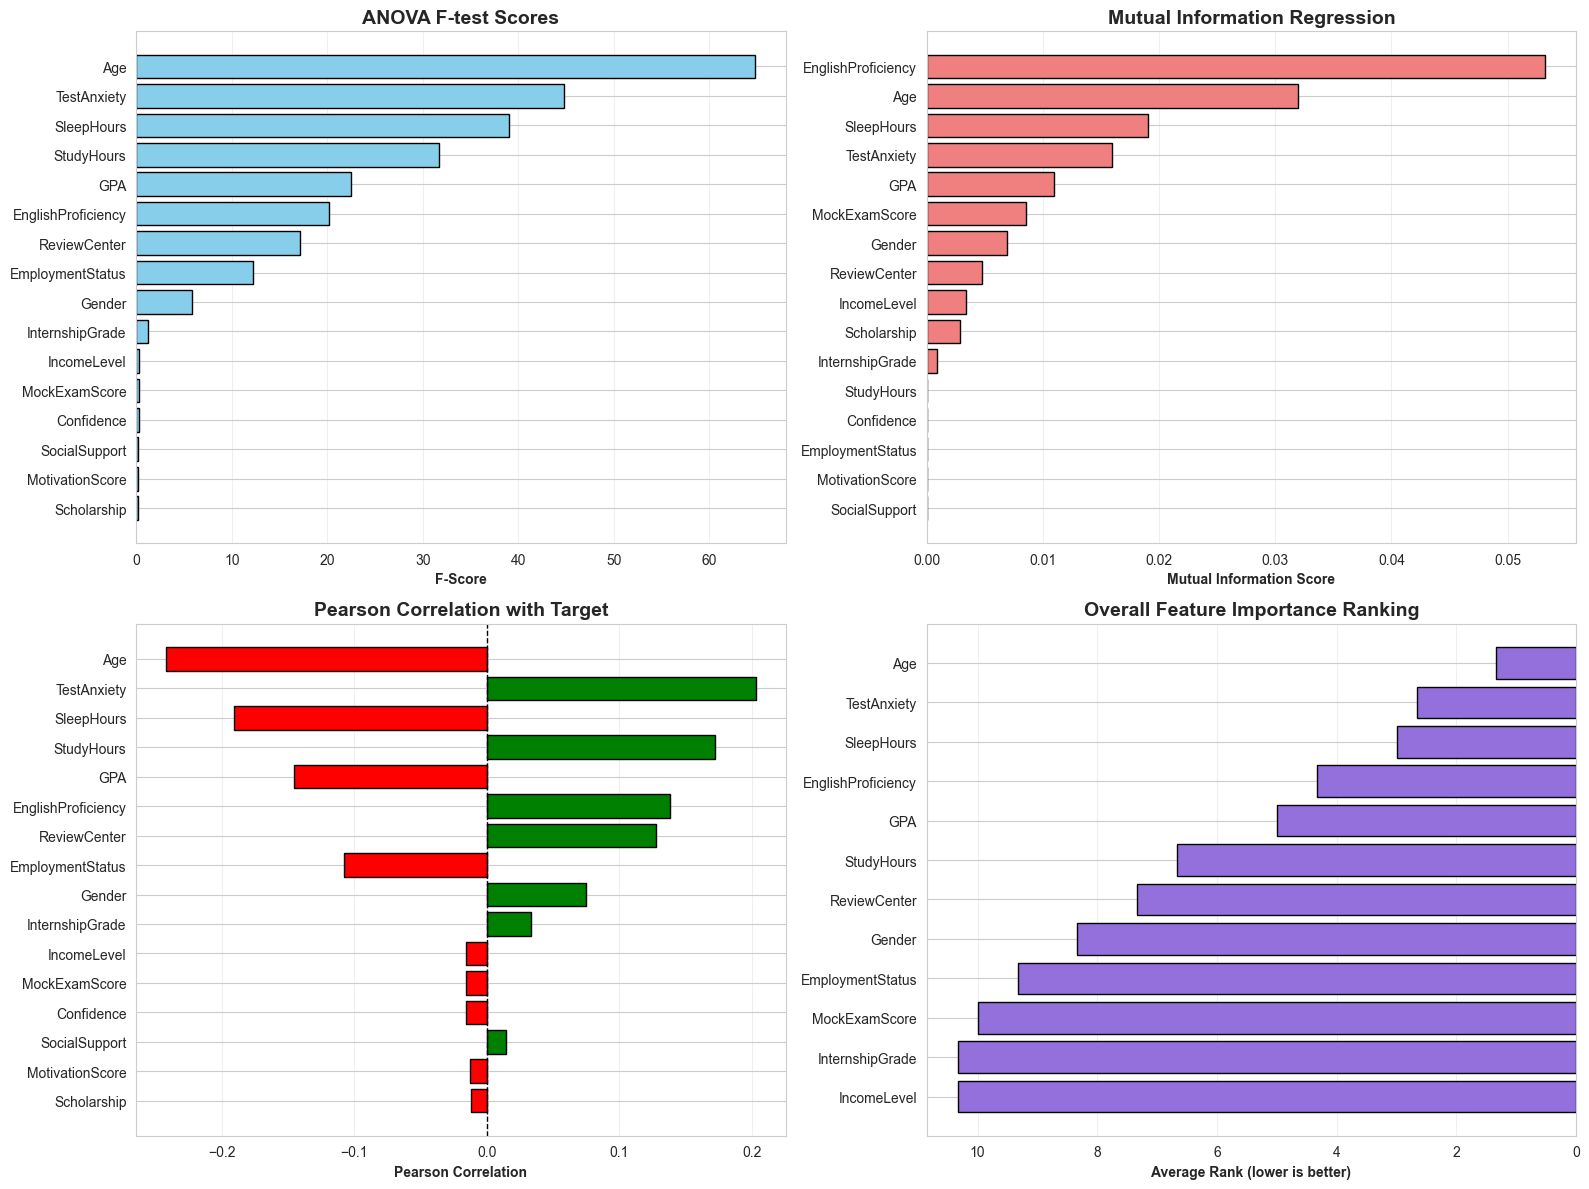


FEATURE IMPORTANCE ANALYSIS COMPLETE

DATA PREPROCESSING FOR MODEL TRAINING

Imputing grade-based columns with IterativeImputer (regression)...

Imputing score-based columns with median...

Data Preprocessing Complete
   Training: 832, Test: 209
   Features: 16
   Target range: [64.50, 81.80]

Final Verification:
   X_train NaN count: 0
   X_test NaN count: 0

Data saved to ../regression_processed_data/
Feature importance results saved to feature_importance_analysis.json
Imputation configuration saved to imputation_config.json
PREPROCESSING COMPLETE


In [4]:
import pandas as pd
import numpy as np
import json
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from scipy.stats import pearsonr
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully")

df = pd.read_csv('../data/sdv_swed.csv')
print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
df.head()

print("=" * 60)
print("DATA EXPLORATION")
print("=" * 60)

print("\nMissing Values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("   No missing values!")
else:
    print(missing[missing > 0])

print(f"\nTarget Distribution:")
print(df['ExamResultPercent'].describe())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['ExamResultPercent'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Exam Result Percentage')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Exam Result Percentages')
axes[0].grid(alpha=0.3)

axes[1].boxplot(df['ExamResultPercent'])
axes[1].set_ylabel('Exam Score')
axes[1].set_title('Exam Score Boxplot')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

numerical_cols = ['Age', 'StudyHours', 'SleepHours', 'Confidence', 'TestAnxiety',
                 'MockExamScore', 'GPA', 'Scholarship', 'InternshipGrade', 'ReviewCenter', 
                 'EnglishProficiency', 'MotivationScore', 'SocialSupport']

correlation_matrix = df[numerical_cols + ['ExamResultPercent']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

target_corr = correlation_matrix['ExamResultPercent'].drop('ExamResultPercent').abs().sort_values(ascending=False)
print("\nTop Features Correlated with Exam Result Percentage:")
for feature, corr in target_corr.head(10).items():
    print(f"   {feature}: {corr:.4f}")

print("=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

X = df.drop(['ExamResultPercent', 'Passed'], axis=1).copy()
y = df['ExamResultPercent'].values

categorical_cols = ['Gender', 'IncomeLevel', 'EmploymentStatus']
binary_cols = ['ReviewCenter']

grade_cols = ['GPA', 'InternshipGrade', 'MockExamScore']
score_cols = ['Age', 'StudyHours', 'SleepHours', 'Confidence', 'TestAnxiety',
              'Scholarship', 'EnglishProficiency', 'MotivationScore', 'SocialSupport']

print("\n[STEP 1] Handling Missing Values...")
print(f"Missing values before imputation:\n{X.isnull().sum()}")

print("\nImputing grade-based columns with IterativeImputer (regression)...")
iterative_imputer = IterativeImputer(random_state=42, max_iter=10)
X[grade_cols] = iterative_imputer.fit_transform(X[grade_cols])

print("\nImputing score-based columns with median...")
median_imputer = SimpleImputer(strategy='median')
X[score_cols] = median_imputer.fit_transform(X[score_cols])

print(f"\nMissing values after imputation:\n{X.isnull().sum()}")
assert X.isnull().sum().sum() == 0, "ERROR: Still have missing values"
print("All missing values handled")

print("\n[STEP 2] Encoding Categorical Variables...")
le = LabelEncoder()
for col in categorical_cols:
    X[col] = le.fit_transform(X[col].astype(str))
    print(f"   Encoded: {col}")

assert not X.isnull().any().any(), "ERROR: NaN after encoding"
assert not np.isnan(y).any(), "ERROR: NaN in target"
print("Data encoding complete")

print("\n" + "=" * 60)
print("[METHOD 1] ANOVA F-test (f_regression)")
print("=" * 60)

selector_f = SelectKBest(score_func=f_regression, k='all')
selector_f.fit(X, y)

f_scores_df = pd.DataFrame({
    'Feature': X.columns,
    'F_Score': selector_f.scores_,
    'P_Value': selector_f.pvalues_
}).sort_values('F_Score', ascending=False)

print("\nANOVA F-test Results:")
for idx, row in f_scores_df.iterrows():
    sig = "***" if row['P_Value'] < 0.001 else "**" if row['P_Value'] < 0.01 else "*" if row['P_Value'] < 0.05 else ""
    print(f"   {row['Feature']:20s}: F={row['F_Score']:8.2f}, p={row['P_Value']:.4f} {sig}")

print("\n" + "=" * 60)
print("[METHOD 2] Mutual Information Regression")
print("=" * 60)

mi_scores = mutual_info_regression(X, y, random_state=42, n_neighbors=5)
mi_scores_df = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("\nMutual Information Scores:")
for idx, row in mi_scores_df.iterrows():
    print(f"   {row['Feature']:20s}: {row['MI_Score']:.6f}")

print("\n" + "=" * 60)
print("[METHOD 3] Pearson Correlation Analysis")
print("=" * 60)

pearson_results = []
for col in X.columns:
    corr_coef, p_value = pearsonr(X[col], y)
    pearson_results.append({
        'Feature': col,
        'Correlation': corr_coef,
        'Abs_Correlation': abs(corr_coef),
        'P_Value': p_value,
        'Significant': p_value < 0.05
    })

pearson_df = pd.DataFrame(pearson_results).sort_values('Abs_Correlation', ascending=False)

print("\nPearson Correlation Results:")
for idx, row in pearson_df.iterrows():
    sig = "***" if row['P_Value'] < 0.001 else "**" if row['P_Value'] < 0.01 else "*" if row['P_Value'] < 0.05 else ""
    print(f"   {row['Feature']:20s}: r={row['Correlation']:7.4f}, p={row['P_Value']:.4f} {sig}")

print("\n" + "=" * 60)
print("COMBINED FEATURE IMPORTANCE RANKING")
print("=" * 60)

combined = f_scores_df.merge(mi_scores_df, on='Feature')
combined = combined.merge(pearson_df[['Feature', 'Correlation', 'Abs_Correlation']], on='Feature')

combined['F_Rank'] = combined['F_Score'].rank(ascending=False, method='min')
combined['MI_Rank'] = combined['MI_Score'].rank(ascending=False, method='min')
combined['Corr_Rank'] = combined['Abs_Correlation'].rank(ascending=False, method='min')
combined['Avg_Rank'] = combined[['F_Rank', 'MI_Rank', 'Corr_Rank']].mean(axis=1)

combined = combined.sort_values('Avg_Rank')

print("\nTop 10 Most Important Features (by average rank):")
print(f"\n{'Rank':<6}{'Feature':<20}{'F-Score':<12}{'MI-Score':<12}{'Pearson r':<12}{'Avg Rank':<10}")
print("-" * 72)
for i, (idx, row) in enumerate(combined.head(12).iterrows(), 1):
    print(f"{i:<6}{row['Feature']:<20}{row['F_Score']:<12.2f}{row['MI_Score']:<12.6f}{row['Correlation']:<12.4f}{row['Avg_Rank']:<10.2f}")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].barh(f_scores_df['Feature'], f_scores_df['F_Score'], color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('F-Score', fontweight='bold')
axes[0, 0].set_title('ANOVA F-test Scores', fontweight='bold', fontsize=14)
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

axes[0, 1].barh(mi_scores_df['Feature'], mi_scores_df['MI_Score'], color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('Mutual Information Score', fontweight='bold')
axes[0, 1].set_title('Mutual Information Regression', fontweight='bold', fontsize=14)
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

colors = ['green' if x > 0 else 'red' for x in pearson_df['Correlation']]
axes[1, 0].barh(pearson_df['Feature'], pearson_df['Correlation'], color=colors, edgecolor='black')
axes[1, 0].set_xlabel('Pearson Correlation', fontweight='bold')
axes[1, 0].set_title('Pearson Correlation with Target', fontweight='bold', fontsize=14)
axes[1, 0].invert_yaxis()
axes[1, 0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].grid(axis='x', alpha=0.3)

axes[1, 1].barh(combined.head(12)['Feature'], combined.head(12)['Avg_Rank'], color='mediumpurple', edgecolor='black')
axes[1, 1].set_xlabel('Average Rank (lower is better)', fontweight='bold')
axes[1, 1].set_title('Overall Feature Importance Ranking', fontweight='bold', fontsize=14)
axes[1, 1].invert_yaxis()
axes[1, 1].invert_xaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFEATURE IMPORTANCE ANALYSIS COMPLETE")

categorical_columns = ['Gender', 'IncomeLevel', 'EmploymentStatus']
numerical_columns = ['Age', 'StudyHours', 'SleepHours', 'Confidence', 'TestAnxiety',
                    'MockExamScore', 'GPA', 'Scholarship', 'InternshipGrade', 
                    'EnglishProficiency', 'MotivationScore', 'SocialSupport']
binary_columns = ['ReviewCenter']

X_final = df[categorical_columns + numerical_columns + binary_columns].copy()
y_final = df['ExamResultPercent'].values

print("\n" + "=" * 60)
print("DATA PREPROCESSING FOR MODEL TRAINING")
print("=" * 60)

grade_columns = ['GPA', 'InternshipGrade', 'MockExamScore']
score_columns = [col for col in numerical_columns if col not in grade_columns]

print("\nImputing grade-based columns with IterativeImputer (regression)...")
iterative_imputer_final = IterativeImputer(random_state=42, max_iter=10)
X_final[grade_columns] = iterative_imputer_final.fit_transform(X_final[grade_columns])

print("\nImputing score-based columns with median...")
median_imputer_final = SimpleImputer(strategy='median')
X_final[score_columns] = median_imputer_final.fit_transform(X_final[score_columns])

X_encoded = X_final.copy()
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

assert not np.isnan(X_scaled).any(), "NaN after scaling"

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_final, test_size=0.2, random_state=42
)

print("\nData Preprocessing Complete")
print(f"   Training: {len(X_train)}, Test: {len(X_test)}")
print(f"   Features: {X_scaled.shape[1]}")
print(f"   Target range: [{y_train.min():.2f}, {y_train.max():.2f}]")

output_dir = '../regression_processed_data'
os.makedirs(output_dir, exist_ok=True)

print("\nFinal Verification:")
print(f"   X_train NaN count: {np.isnan(X_train).sum()}")
print(f"   X_test NaN count: {np.isnan(X_test).sum()}")

if np.isnan(X_train).any() or np.isnan(X_test).any():
    print("ERROR: Data contains NaN")
else:
    np.save(f'{output_dir}/X_train.npy', X_train)
    np.save(f'{output_dir}/X_test.npy', X_test)
    np.save(f'{output_dir}/y_train.npy', y_train)
    np.save(f'{output_dir}/y_test.npy', y_test)

    joblib.dump(scaler, f'{output_dir}/scaler.pkl')
    joblib.dump(label_encoders, f'{output_dir}/label_encoders.pkl')
    joblib.dump(iterative_imputer_final, f'{output_dir}/iterative_imputer.pkl')
    joblib.dump(median_imputer_final, f'{output_dir}/median_imputer.pkl')

    feature_names = categorical_columns + numerical_columns + binary_columns
    with open(f'{output_dir}/feature_names.json', 'w') as f:
        json.dump(feature_names, f)

    imputation_config = {
        'grade_columns': grade_columns,
        'score_columns': score_columns,
        'grade_imputer': 'IterativeImputer',
        'score_imputer': 'SimpleImputer_median'
    }

    with open(f'{output_dir}/imputation_config.json', 'w') as f:
        json.dump(imputation_config, f, indent=2)

    feature_importance_results = {
        'anova_f_test': f_scores_df.to_dict('records'),
        'mutual_information': mi_scores_df.to_dict('records'),
        'pearson_correlation': pearson_df.to_dict('records'),
        'combined_ranking': combined.to_dict('records')
    }

    with open(f'{output_dir}/feature_importance_analysis.json', 'w') as f:
        json.dump(feature_importance_results, f, indent=2)

    print(f"\nData saved to {output_dir}/")
    print("Feature importance results saved to feature_importance_analysis.json")
    print("Imputation configuration saved to imputation_config.json")
    print("PREPROCESSING COMPLETE")